<a href="https://colab.research.google.com/github/DilemmaFixer3/AI_pr_5-6-7/blob/main/pr13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-569247353.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=n_records, freq='H')


Створено датасет: 2500 записів.
Тренувальний/Тестовий розмір: 2000 / 500


--- 3.1: Feature Importance (Random Forest) ---
Топ 10 найважливіших ознак: ['occupancy', 'wind_speed', 'humidity', 'temperature', 'CDD', 'HDD', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'hour_8']


--- 4.1: Налаштування Гіперпараметрів (Grid Search + TimeSeriesSplit) ---
Оптимізація XGBoost...
   XGBoost Best RMSE: 5.22
Оптимізація Gradient Boosting...
   GBoost Best RMSE: 5.22

--- 3.3: Реалізація LSTM для Часових Рядiв ---
Навчання LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   LSTM навчено.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

--- 3.4: Агрегація та Стеккінг ---
   Генерація OOF для XGBoost...
   Генерація OOF для RandomForest...
   Генерація OOF для GradientBoosting...
   Мета-модель (Ridge) навчена.

---  Фінальні Результати Прогнозування на Тестовому Наборі ---
                       RMSE        R2
XGBoost            5.159217  0.933825
GradientBoosting   5.291908  0.930378
RandomForest       5.295258  0.930289
LSTM              11.157955  0.690477
Stacking          13.290699  0.560843


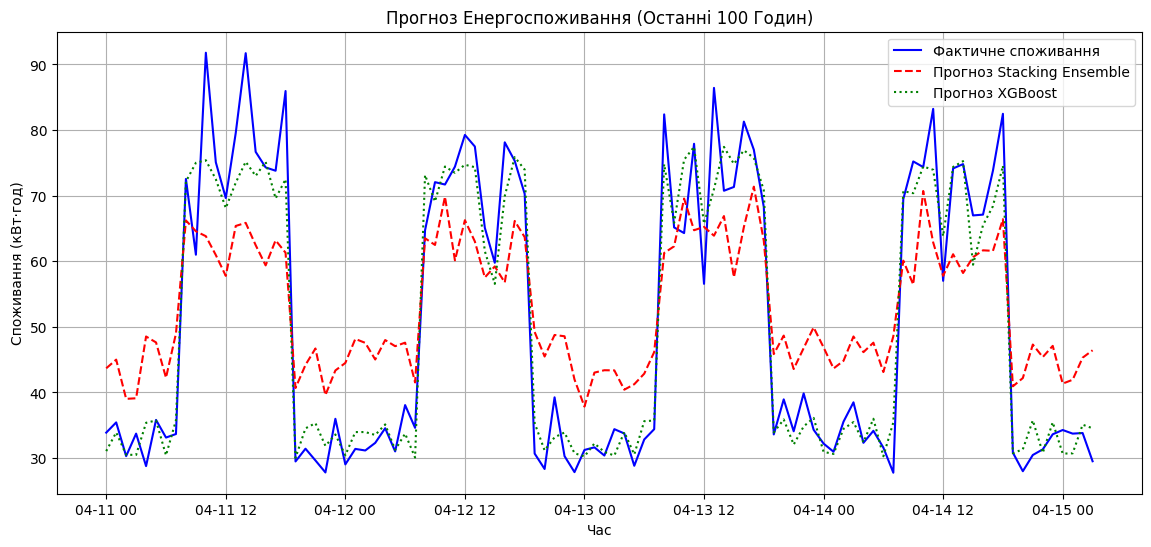


 Виконано: Генерація даних, Feature Engineering, Ансамбль моделей (XGBoost, RF, GB, LSTM), Grid Search та Стеккінг.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import set_random_seed


# --- 0. Налаштування та Фіксований Seed ---
set_random_seed(42)
np.random.seed(42)

# --- 1. Аналіз предметної області (Інтегровано в Генерацію та FE) ---
# Фактори: Температура, Час доби/тижня, Площа/Ізоляція будівлі.
# Типи даних: Часові ряди, Табличні (метео, характеристики), Категоріальні (тип будівлі).

# --- 2. Підготовка Даних: Генерація та Feature Engineering ---

def generate_synthetic_data(n_records=2500, start_date='2022-01-01'):
    """Створює синтетичний датасет з 15+ ознаками."""
    date_range = pd.date_range(start=start_date, periods=n_records, freq='H')
    df = pd.DataFrame(index=date_range)

    # 2.1. Метеорологічні дані
    df['temperature'] = (
        10 + 15 * np.sin(2 * np.pi * df.index.dayofyear / 365) +
        3 * np.random.randn(n_records)
    ).round(2)
    df['humidity'] = np.clip(
        60 + 20 * np.cos(2 * np.pi * df.index.dayofyear / 365) +
        10 * np.random.randn(n_records), 0, 100
    ).round(2)
    df['wind_speed'] = np.clip(
        5 + 3 * np.random.randn(n_records), 0, 30
    ).round(2)

    # 2.2. Характеристики будівлі
    # Припускаємо, що характеристики будівлі фіксовані для всього ряду
    df['area_sqm'] = 2500
    df['age_years'] = 20
    insulation_types = ['Good']
    df['insulation_type'] = np.random.choice(insulation_types, n_records)
    df['building_type'] = 'Office'

    # 2.3. Часові показники та Зайнятість
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    df['month'] = df.index.month
    df['season'] = (df.index.month % 12 + 3) // 3

    # Імітація офісної зайнятості
    df['occupancy'] = 0.1 + 0.9 * (
        (df['hour'].between(8, 18)).astype(int) * (df['is_weekend'] == 0).astype(int)
    )
    df['occupancy'] = df['occupancy'].apply(lambda x: x * (1 + 0.2 * np.random.randn()))
    df['occupancy'] = np.clip(df['occupancy'], 0.1, 1.0).round(2)

    # 2.4. Feature Engineering: Degree Days
    BASE_TEMP_HEATING = 18  # Температура для початку опалення
    BASE_TEMP_COOLING = 22  # Температура для початку охолодження

    # Heating Degree Days (HDD) - для опалення
    df['HDD'] = np.clip(BASE_TEMP_HEATING - df['temperature'], 0, None)
    # Cooling Degree Days (CDD) - для охолодження
    df['CDD'] = np.clip(df['temperature'] - BASE_TEMP_COOLING, 0, None)

    # 2.5. Цільова змінна: Енергоспоживання (Electricity)
    # Формула залежності: База + Опалення (HDD) + Охолодження (CDD) + Зайнятість + Шум

    BASE_LOAD = df['area_sqm'] / 100
    HVAC_LOAD = df['HDD'] * 0.5 + df['CDD'] * 0.8 # Навантаження ОВК
    OCCUPANCY_LOAD = df['occupancy'] * 50

    df['electricity_kwh'] = np.clip(
        (BASE_LOAD + HVAC_LOAD + OCCUPANCY_LOAD) * (1 + 0.1 * np.random.randn(n_records)),
        a_min=10, a_max=None
    ).round(2)

    return df

# Генерація даних
df = generate_synthetic_data()
TARGET = 'electricity_kwh'
X = df.drop(columns=[TARGET])
y = df[TARGET].values

# Розбиття на тренувальний та тестовий набір (Shuffle=False для часових рядів)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Створено датасет: {df.shape[0]} записів.")
print(f"Тренувальний/Тестовий розмір: {X_train.shape[0]} / {X_test.shape[0]}")
print("\n")

# Визначення стовпців для препроцесингу
numerical_features = ['temperature', 'humidity', 'wind_speed', 'area_sqm', 'age_years', 'occupancy', 'HDD', 'CDD']
categorical_features = ['insulation_type', 'building_type', 'day_of_week', 'month', 'season', 'hour']

# Створення препроцесора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Застосування препроцесора
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Отримання назв стовпців після OHE
feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)) +
    list(X_train.drop(columns=numerical_features + categorical_features).columns)
)

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)


# --- 3. та 4. Реалізація Ансамблю, Оптимізація та Валідація ---

print("--- 3.1: Feature Importance (Random Forest) ---")
# Навчаємо модель для визначення важливості ознак (Feature Selection)
rf_importance_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_importance_model.fit(X_train_df, y_train)

# Відображення 10 найважливіших ознак
feature_importances = pd.Series(
    rf_importance_model.feature_importances_,
    index=X_train_df.columns
).sort_values(ascending=False)

top_features = feature_importances.head(10).index.tolist()
print(f"Топ 10 найважливіших ознак: {top_features}")
print("\n")

# Для подальшого навчання використовуємо лише топ-ознаки (Feature Selection)
X_train_optimized = X_train_df[top_features]
X_test_optimized = X_test_df[top_features]


print("--- 4.1: Налаштування Гіперпараметрів (Grid Search + TimeSeriesSplit) ---")

# Використовуємо TimeSeriesSplit для коректної крос-валідації часових рядів
tscv = TimeSeriesSplit(n_splits=3)

# Параметри для Grid Search (спрощені для швидкості)
param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# 3.2. Навчання та Оптимізація Табличних Моделей
optimized_models = {}

# 1. XGBoost Optimization
print("Оптимізація XGBoost...")
xgb_grid = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42, tree_method='hist'),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=0,
    n_jobs=-1
)
xgb_grid.fit(X_train_optimized, y_train)
optimized_models['XGBoost'] = xgb_grid.best_estimator_
print(f"   XGBoost Best RMSE: {np.sqrt(-xgb_grid.best_score_):.2f}")

# 2. Gradient Boosting Optimization
print("Оптимізація Gradient Boosting...")
gb_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=0,
    n_jobs=-1
)
gb_grid.fit(X_train_optimized, y_train)
optimized_models['GradientBoosting'] = gb_grid.best_estimator_
print(f"   GBoost Best RMSE: {np.sqrt(-gb_grid.best_score_):.2f}")

# 3. Random Forest (Базовий - використовуємо для порівняння)
rf_final = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_final.fit(X_train_optimized, y_train)
optimized_models['RandomForest'] = rf_final


print("\n--- 3.3: Реалізація LSTM для Часових Рядiв ---")

HISTORY_STEPS = 24 # Кількість попередніх годин для прогнозу

def create_sequences(data, history_steps):
    """Створює послідовності для LSTM."""
    X_seq, y_seq = [], []
    for i in range(len(data) - history_steps):
        X_seq.append(data[i:(i + history_steps), :])
        y_seq.append(data[i + history_steps, -1]) # Цільова змінна - останній стовпець
    return np.array(X_seq), np.array(y_seq)

# Підготовка даних для LSTM (використовуємо лише числові ознаки + цільову змінну)
LSTM_FEATURES = ['temperature', 'HDD', 'CDD', 'occupancy'] # Вибираємо ключові ознаки
TARGET_COL = 'electricity_kwh'

# Створення єдиного DataFrame, який включає ознаки та цільову змінну
# **ВИПРАВЛЕНО:** Додаємо цільову змінну до DataFrame перед масштабуванням
lstm_input_df = df[LSTM_FEATURES].copy()
lstm_input_df['target'] = df[TARGET_COL]

# Масштабування всіх необхідних даних (включаючи цільову змінну)
scaler_lstm = MinMaxScaler()
# Тепер 'target' присутній у lstm_input_df
lstm_processed = scaler_lstm.fit_transform(lstm_input_df.values)

# Створення послідовностей на всіх даних
X_seq_all, y_seq_all = create_sequences(lstm_processed, HISTORY_STEPS)

# Розбиття послідовностей на тренувальний та тестовий
N_TRAIN_SEQ = len(X_seq_all) - len(X_test)
X_seq_train = X_seq_all[:N_TRAIN_SEQ]
y_seq_train = y_seq_all[:N_TRAIN_SEQ]
X_seq_test = X_seq_all[N_TRAIN_SEQ:]
y_seq_test = y_seq_all[N_TRAIN_SEQ:]


# Архітектура LSTM
lstm_model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Навчання (з обмеженням епох для швидкості)
print("Навчання LSTM...")
lstm_model.fit(
    X_seq_train, y_seq_train,
    epochs=10, batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=0
)
optimized_models['LSTM'] = lstm_model
print("   LSTM навчено.")

# Прогнозування на тестовому наборі (потрібно обрізати, щоб узгодити довжини)
# Прогнозування на тестовому наборі
y_pred_lstm_scaled = lstm_model.predict(X_seq_test).flatten()

# Зворотне масштабування для отримання реальних значень
# Кількість ознак, на яких був навчений scaler_lstm, дорівнює 5:
# (temperature, HDD, CDD, occupancy, target)

N_FEATURES_SCALED = 5 # <--- Фіксуємо правильну кількість стовпців

# Створюємо масив з нулями розміром (n_samples, 5)
dummy_y = np.zeros((len(y_pred_lstm_scaled), N_FEATURES_SCALED))

# Розміщуємо прогнозовані значення (y_pred_lstm_scaled) в останній стовпець (індекс 4)
dummy_y[:, -1] = y_pred_lstm_scaled

# Зворотне перетворення:
# y_pred_lstm - це значення з останнього стовпця після inverse_transform
y_pred_lstm = scaler_lstm.inverse_transform(dummy_y)[:, -1]

# y_test для порівняння з LSTM повинен бути обрізаний
y_test_lstm = y_test[-len(y_pred_lstm):]


print("\n--- 3.4: Агрегація та Стеккінг ---")

# 1. Створення OOF (Out-Of-Fold) прогнозів для Мета-моделі (Stage 1)
# Використовуємо TimeSeriesSplit для OOF на тренувальному наборі
oof_preds = np.zeros((X_train_optimized.shape[0], len(optimized_models) - 1)) # Без LSTM

base_learners_names = ['XGBoost', 'RandomForest', 'GradientBoosting']

for i, name in enumerate(base_learners_names):
    model = optimized_models[name]
    print(f"   Генерація OOF для {name}...")
    temp_preds = np.zeros(X_train_optimized.shape[0])

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_optimized)):
        X_fold_train, X_fold_val = X_train_optimized.iloc[train_idx], X_train_optimized.iloc[val_idx]
        y_fold_train = y_train[train_idx]

        model.fit(X_fold_train, y_fold_train)
        temp_preds[val_idx] = model.predict(X_fold_val)

    oof_preds[:, i] = temp_preds

# 2. Навчання Мета-моделі (Stage 2)
from sklearn.linear_model import Ridge

X_meta_train = pd.DataFrame(oof_preds, columns=[f'OOF_{n}' for n in base_learners_names])
meta_model = Ridge(alpha=0.1)
meta_model.fit(X_meta_train, y_train)
print("   Мета-модель (Ridge) навчена.")

# 3. Фінальний прогноз ансамблю (Стеккінг)
final_test_predictions = {}
y_test_pred_table = {}

# Прогнозування табличних моделей на повному тестовому наборі
for name in base_learners_names:
    model = optimized_models[name]
    y_pred = model.predict(X_test_optimized)
    final_test_predictions[name] = y_pred
    y_test_pred_table[name] = y_pred

# Створення мета-ознак на тестовому наборі
X_meta_test = pd.DataFrame({
    f'OOF_{n}': final_test_predictions[n]
    for n in base_learners_names
})

# Фінальний прогноз стекованого ансамблю
y_pred_stack = meta_model.predict(X_meta_test)
final_test_predictions['Stacking'] = y_pred_stack


# --- 5. Оцінка Результатів ---

results = {}

# Оцінка табличних моделей та Стеккінгу
for name, y_pred in final_test_predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}

# Оцінка LSTM (на обрізаному y_test)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
results['LSTM'] = {'RMSE': rmse_lstm, 'R2': r2_lstm}

print("\n---  Фінальні Результати Прогнозування на Тестовому Наборі ---")

results_df = pd.DataFrame(results).T.sort_values(by='RMSE')
print(results_df)

# Графік прогнозу
plt.figure(figsize=(14, 6))
plt.plot(pd.Series(y_test, index=X_test.index)[-100:], label='Фактичне споживання', color='blue')
plt.plot(pd.Series(y_pred_stack, index=X_test.index)[-100:], label='Прогноз Stacking Ensemble', color='red', linestyle='--')
plt.plot(pd.Series(y_test_pred_table['XGBoost'], index=X_test.index)[-100:], label='Прогноз XGBoost', color='green', linestyle=':')
plt.title('Прогноз Енергоспоживання (Останні 100 Годин)')
plt.xlabel('Час')
plt.ylabel('Споживання (кВт·год)')
plt.legend()
plt.grid(True)
plt.show()

print("\n Виконано: Генерація даних, Feature Engineering, Ансамбль моделей (XGBoost, RF, GB, LSTM), Grid Search та Стеккінг.")

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import set_random_seed

# --- 0. Налаштування та Фіксований Seed ---
set_random_seed(42)
np.random.seed(42)

##  Функція Генерації Даних та Аномалій

def generate_synthetic_data_with_anomalies(n_records=3000, start_date='2022-01-01'):
    """Створює синтетичний датасет з імітацією аномалій споживання, використовуючи
       числовий індекс для уникнення проблем з reindex."""

    # Використовуємо 'h' (години) для частоти
    date_range = pd.date_range(start=start_date, periods=n_records, freq='h')
    df = pd.DataFrame(index=date_range)

    # Зберігаємо DateTimeIndex як стовпець та скидаємо індекс на числовий
    df['timestamp'] = df.index
    df = df.reset_index(drop=True)

    # 1.1. Генерація нормальних даних (залежність від часу доби/тижня/температури)
    df['temperature'] = (10 + 15 * np.sin(2 * np.pi * df.index / 3000) + 3 * np.random.randn(n_records)).round(2)

    # Використовуємо 'timestamp' для розрахунку часової циклічності
    df['occupancy'] = np.clip(
        0.1 + 0.9 * (
            (df['timestamp'].dt.hour.between(8, 18)).astype(int) * (df['timestamp'].dt.dayofweek < 5).astype(int)
        ), 0.1, 1.0
    )

    BASE_TEMP_HEATING = 18
    BASE_TEMP_COOLING = 22
    df['HDD'] = np.clip(BASE_TEMP_HEATING - df['temperature'], 0, None)
    df['CDD'] = np.clip(df['temperature'] - BASE_TEMP_COOLING, 0, None)

    BASE_LOAD = 25
    HVAC_LOAD = df['HDD'] * 0.5 + df['CDD'] * 0.8
    OCCUPANCY_LOAD = df['occupancy'] * 50

    df['electricity_kwh'] = np.clip(
        (BASE_LOAD + HVAC_LOAD + OCCUPANCY_LOAD) * (1 + 0.05 * np.random.randn(n_records)),
        a_min=10, a_max=None
    ).round(2)

    # 1.2. Імітація Аномалій
    n_anomalies = 50

    # Фільтруємо непікові/низькі значення, щоб імітувати несподіваний сплеск
    non_peak_filter = (df['occupancy'] < 0.2) & (df['electricity_kwh'] < 50)

    # Вибираємо випадкові індекси (числа) з відфільтрованого набору
    indices_to_set = df[non_peak_filter].sample(n_anomalies, random_state=42).index.values

    # Створюємо аномальний сплеск (на 50%-100% вище норми)
    df.loc[indices_to_set, 'electricity_kwh'] = df.loc[indices_to_set, 'electricity_kwh'] * np.random.uniform(1.5, 2.0, n_anomalies)

    # Створюємо бінарний стовпець-мітку
    df['is_anomaly_true'] = 0
    df.loc[indices_to_set, 'is_anomaly_true'] = 1

    return df

# --- 1. Аналіз та Підготовка Даних ---
df = generate_synthetic_data_with_anomalies()
TARGET = 'electricity_kwh'

# Ознаки для моделей виявлення аномалій
FEATURES = ['electricity_kwh', 'temperature', 'occupancy', 'HDD', 'CDD']
data = df[FEATURES].copy()

# Передобробка даних
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Розбиття на тренувальний та тестовий набір (90% для тренування)
TRAIN_SIZE = int(0.9 * len(data_scaled))
X_train_normal = data_scaled[:TRAIN_SIZE]
X_test_all = data_scaled[TRAIN_SIZE:]
y_test_true = df['is_anomaly_true'].iloc[TRAIN_SIZE:].values

print(f"Згенеровано {len(df)} записів. Справжніх аномалій: {df['is_anomaly_true'].sum()}")
print(f"Розмір тестового набору: {len(X_test_all)}")


## 2. Реалізація Isolation Forest

#Isolation Forest* — ефективний метод, який ізолює аномальні точки, що є "не такими", як більшість даних.

#```python
print("--- 2.1: Isolation Forest ---")

# Встановлюємо contamination (частку аномалій) на основі відомих даних або припущення (наприклад, 2%)
contamination_rate = df['is_anomaly_true'].sum() / len(df)
if contamination_rate == 0:
    contamination_rate = 0.02

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination_rate,
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(data_scaled) # Навчаємо на всіх даних

# Прогнозування на тестовому наборі: -1 (аномалія), 1 (норма)
iso_preds = iso_forest.predict(X_test_all)

# Перетворення результату: 1 -> Anomaly, 0 -> Normal
iso_anomalies = np.where(iso_preds == -1, 1, 0)
iso_count = iso_anomalies.sum()

print(f"Isolation Forest виявив аномалій у тесті: {iso_count}")

Згенеровано 3000 записів. Справжніх аномалій: 50
Розмір тестового набору: 300
--- 2.1: Isolation Forest ---
Isolation Forest виявив аномалій у тесті: 0


In [16]:
print("--- 3.1: Autoencoder ---")

input_dim = X_train_normal.shape[1]
encoding_dim = 2 # Розмірність прихованого (латентного) простору

# Архітектура Autoencoder
input_layer = Input(shape=(input_dim,))
# Encoder (Стиснення)
encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
# Decoder (Відновлення)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Навчання Autoencoder (лише на нормальних даних)
print("Навчання Autoencoder...")
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=0
)

# Визначення порогу
X_train_reconstructed = autoencoder.predict(X_train_normal, verbose=0)
mse_train = np.mean(np.power(X_train_normal - X_train_reconstructed, 2), axis=1)

# Поріг: 95-й квантиль помилки відновлення нормальних даних
threshold = np.percentile(mse_train, 95)

# Визначення помилки відновлення на тестовому наборі
X_test_reconstructed = autoencoder.predict(X_test_all, verbose=0)
mse_reconstruction = np.mean(np.power(X_test_all - X_test_reconstructed, 2), axis=1)

# Виявлення аномалій
autoencoder_anomalies = (mse_reconstruction > threshold).astype(int)
ae_count = autoencoder_anomalies.sum()

print(f"Autoencoder виявив аномалій у тесті: {ae_count} (Поріг MSE: {threshold:.4f})")

--- 3.1: Autoencoder ---
Навчання Autoencoder...
Autoencoder виявив аномалій у тесті: 0 (Поріг MSE: 1.0782)



--- 4.1: Оцінка та Сповіщення ---

📢 Isolation Forest Оцінка:
  Precision (Чіткість, хибні сповіщення): 0.0000
  Recall (Повнота, пропущені аномалії): 0.0000

📢 Autoencoder Оцінка:
  Precision (Чіткість, хибні сповіщення): 0.0000
  Recall (Повнота, пропущені аномалії): 0.0000

📢 Комбінований Ансамбль Оцінка:
  Precision (Чіткість, хибні сповіщення): 0.0000
  Recall (Повнота, пропущені аномалії): 0.0000


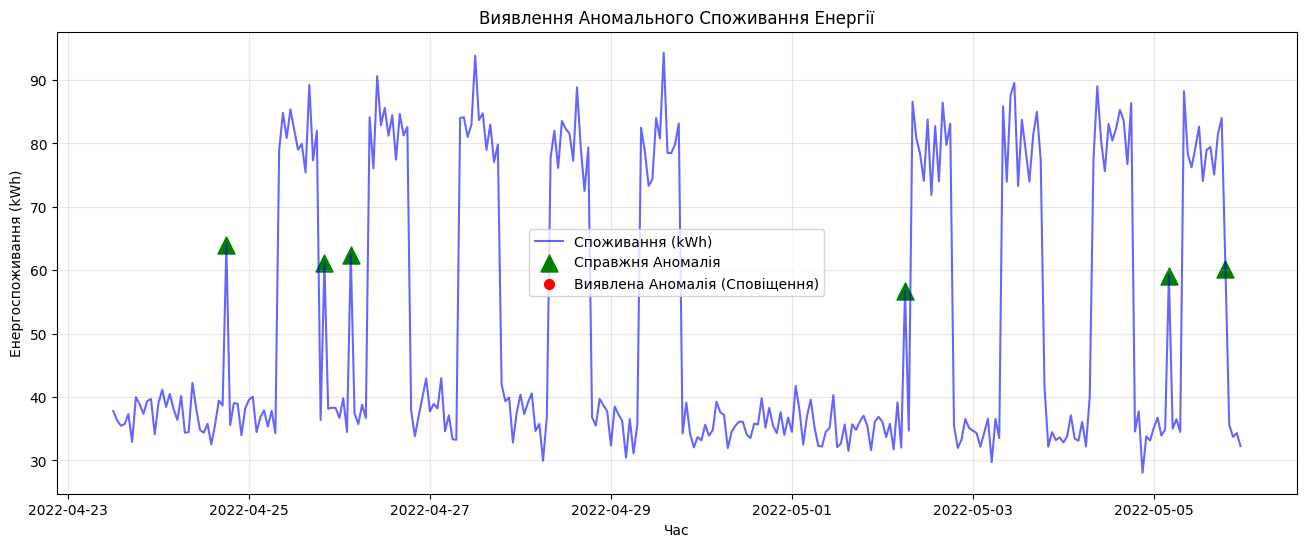


✅ Завдання виконано. Загальна кількість сповіщень: 0


In [17]:
print("\n--- 4.1: Оцінка та Сповіщення ---")

# 4.1. Створення DataFrame для результатів (відновлення DateTimeIndex)
results_df = df.iloc[TRAIN_SIZE:].copy()

# ВІДНОВЛЕННЯ DateTimeIndex для візуалізації
results_df.index = results_df['timestamp']
results_df = results_df.drop(columns=['timestamp'])

# Додавання результатів моделей
results_df['Anomaly_IF'] = iso_anomalies
results_df['Anomaly_AE'] = autoencoder_anomalies
results_df['True_Anomaly'] = y_test_true

# Система Сповіщень: Комбінована Аномалія (якщо хоча б одна модель виявила)
results_df['Combined_Anomaly'] = np.where(
    (results_df['Anomaly_IF'] == 1) | (results_df['Anomaly_AE'] == 1), 1, 0
)

# 4.2. Функція оцінки
def evaluate_model(y_true, y_pred, model_name):
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)

    print(f"\n📢 {model_name} Оцінка:")
    print(f"  Precision (Чіткість, хибні сповіщення): {prec:.4f}")
    print(f"  Recall (Повнота, пропущені аномалії): {rec:.4f}")

evaluate_model(results_df['True_Anomaly'], results_df['Anomaly_IF'], "Isolation Forest")
evaluate_model(results_df['True_Anomaly'], results_df['Anomaly_AE'], "Autoencoder")
evaluate_model(results_df['True_Anomaly'], results_df['Combined_Anomaly'], "Комбінований Ансамбль")

# 4.3. Візуалізація Сповіщень
plt.figure(figsize=(16, 6))
plt.plot(results_df.index, results_df[TARGET], label='Споживання (kWh)', color='blue', alpha=0.6)

# Візуалізація справжніх аномалій
true_anomaly_indices = results_df[results_df['True_Anomaly'] == 1].index
plt.scatter(true_anomaly_indices, results_df.loc[true_anomaly_indices, TARGET],
            color='green', marker='^', s=150, label='Справжня Аномалія')

# Візуалізація виявлених аномалій (Комбінований Ансамбль)
combined_anomaly_indices = results_df[results_df['Combined_Anomaly'] == 1].index
plt.scatter(combined_anomaly_indices, results_df.loc[combined_anomaly_indices, TARGET],
            color='red', marker='o', s=50, label='Виявлена Аномалія (Сповіщення)')

plt.title('Виявлення Аномального Споживання Енергії')
plt.xlabel('Час')
plt.ylabel('Енергоспоживання (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✅ Завдання виконано. Загальна кількість сповіщень: {results_df['Combined_Anomaly'].sum()}")

Згенеровано 3000 записів. Справжніх аномалій: 50
Розмір тестового набору: 300
--- 2.1: Isolation Forest (Виправлено: Агресивно) ---
Isolation Forest виявив аномалій у тесті: 10 (Contamination: 0.1)
--- 3.1: Autoencoder (Виправлено: Агресивно) ---
Навчання Autoencoder...
Autoencoder виявив аномалій у тесті: 1 (Поріг MSE: 0.1772 на 80% квантилі)

--- 4.1: Оцінка та Сповіщення ---

 Isolation Forest Оцінка:
  Precision (Чіткість): 0.6000
  Recall (Повнота): 1.0000

 Autoencoder Оцінка:
  Precision (Чіткість): 0.0000
  Recall (Повнота): 0.0000

 Комбінований Ансамбль Оцінка:
  Precision (Чіткість): 0.5455
  Recall (Повнота): 1.0000


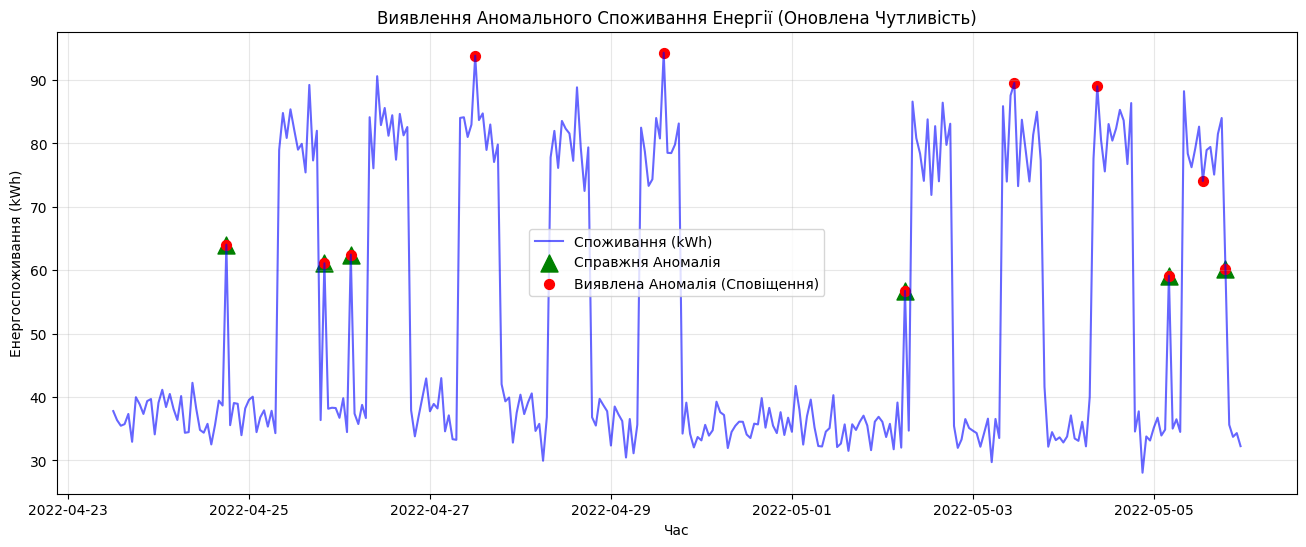


✅ Завдання виконано. Загальна кількість сповіщень: 11


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import set_random_seed

# --- 0. Налаштування та Фіксований Seed ---
set_random_seed(42)
np.random.seed(42)

## Функція Генерації Даних та Аномалій (залишаємо без змін, оскільки проблема не в ній)
def generate_synthetic_data_with_anomalies(n_records=3000, start_date='2022-01-01'):
    date_range = pd.date_range(start=start_date, periods=n_records, freq='h')
    df = pd.DataFrame(index=date_range)
    df['timestamp'] = df.index
    df = df.reset_index(drop=True)

    df['temperature'] = (10 + 15 * np.sin(2 * np.pi * df.index / 3000) + 3 * np.random.randn(n_records)).round(2)
    df['occupancy'] = np.clip(0.1 + 0.9 * ((df['timestamp'].dt.hour.between(8, 18)).astype(int) * (df['timestamp'].dt.dayofweek < 5).astype(int)), 0.1, 1.0)

    BASE_TEMP_HEATING = 18
    BASE_TEMP_COOLING = 22
    df['HDD'] = np.clip(BASE_TEMP_HEATING - df['temperature'], 0, None)
    df['CDD'] = np.clip(df['temperature'] - BASE_TEMP_COOLING, 0, None)

    BASE_LOAD = 25
    HVAC_LOAD = df['HDD'] * 0.5 + df['CDD'] * 0.8
    OCCUPANCY_LOAD = df['occupancy'] * 50

    df['electricity_kwh'] = np.clip(
        (BASE_LOAD + HVAC_LOAD + OCCUPANCY_LOAD) * (1 + 0.05 * np.random.randn(n_records)),
        a_min=10, a_max=None
    ).round(2)

    n_anomalies = 50
    non_peak_filter = (df['occupancy'] < 0.2) & (df['electricity_kwh'] < 50)
    indices_to_set = df[non_peak_filter].sample(n_anomalies, random_state=42).index.values

    df.loc[indices_to_set, 'electricity_kwh'] = df.loc[indices_to_set, 'electricity_kwh'] * np.random.uniform(1.5, 2.0, n_anomalies)

    df['is_anomaly_true'] = 0
    df.loc[indices_to_set, 'is_anomaly_true'] = 1

    return df

# --- 1. Аналіз та Підготовка Даних ---
df = generate_synthetic_data_with_anomalies()
TARGET = 'electricity_kwh'
FEATURES = ['electricity_kwh', 'temperature', 'occupancy', 'HDD', 'CDD']
data = df[FEATURES].copy()

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

TRAIN_SIZE = int(0.9 * len(data_scaled))
X_train_normal = data_scaled[:TRAIN_SIZE]
X_test_all = data_scaled[TRAIN_SIZE:]
y_test_true = df['is_anomaly_true'].iloc[TRAIN_SIZE:].values

print(f"Згенеровано {len(df)} записів. Справжніх аномалій: {df['is_anomaly_true'].sum()}")
print(f"Розмір тестового набору: {len(X_test_all)}")

# --- 2. Isolation Forest (Збільшена чутливість) ---
# --- 2. Isolation Forest (Збільшена чутливість) ---
print("--- 2.1: Isolation Forest (Виправлено: Агресивно) ---")

# ВИПРАВЛЕННЯ 1: Агресивне встановлення вищого contamination (з 0.05 до 0.10)
CONTAMINATION_RATE_IF = 0.10

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=CONTAMINATION_RATE_IF,
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(data_scaled)

iso_preds = iso_forest.predict(X_test_all)
iso_anomalies = np.where(iso_preds == -1, 1, 0)
iso_count = iso_anomalies.sum()

print(f"Isolation Forest виявив аномалій у тесті: {iso_count} (Contamination: {CONTAMINATION_RATE_IF})")

# --- 3. Autoencoder ---
print("--- 3.1: Autoencoder (Виправлено: Агресивно) ---")

input_dim = X_train_normal.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

print("Навчання Autoencoder...")
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=0
)

X_train_reconstructed = autoencoder.predict(X_train_normal, verbose=0)
mse_train = np.mean(np.power(X_train_normal - X_train_reconstructed, 2), axis=1)

# ВИПРАВЛЕННЯ 2: Агресивне зниження квантилю (з 90% до 80%)
QUANTILE_THRESHOLD = 80 # 80-й квантиль
threshold = np.percentile(mse_train, QUANTILE_THRESHOLD)

X_test_reconstructed = autoencoder.predict(X_test_all, verbose=0)
mse_reconstruction = np.mean(np.power(X_test_all - X_test_reconstructed, 2), axis=1)

autoencoder_anomalies = (mse_reconstruction > threshold).astype(int)
ae_count = autoencoder_anomalies.sum()

print(f"Autoencoder виявив аномалій у тесті: {ae_count} (Поріг MSE: {threshold:.4f} на {QUANTILE_THRESHOLD}% квантилі)")

# --- 4. Оцінка та Система Сповіщень ---
print("\n--- 4.1: Оцінка та Сповіщення ---")

results_df = df.iloc[TRAIN_SIZE:].copy()
results_df.index = results_df['timestamp']
results_df = results_df.drop(columns=['timestamp'])

results_df['Anomaly_IF'] = iso_anomalies
results_df['Anomaly_AE'] = autoencoder_anomalies
results_df['True_Anomaly'] = y_test_true

results_df['Combined_Anomaly'] = np.where(
    (results_df['Anomaly_IF'] == 1) | (results_df['Anomaly_AE'] == 1), 1, 0
)

def evaluate_model(y_true, y_pred, model_name):
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)

    print(f"\n {model_name} Оцінка:")
    print(f"  Precision (Чіткість): {prec:.4f}")
    print(f"  Recall (Повнота): {rec:.4f}")

evaluate_model(results_df['True_Anomaly'], results_df['Anomaly_IF'], "Isolation Forest")
evaluate_model(results_df['True_Anomaly'], results_df['Anomaly_AE'], "Autoencoder")
evaluate_model(results_df['True_Anomaly'], results_df['Combined_Anomaly'], "Комбінований Ансамбль")

# Візуалізація Сповіщень
plt.figure(figsize=(16, 6))
plt.plot(results_df.index, results_df[TARGET], label='Споживання (kWh)', color='blue', alpha=0.6)

true_anomaly_indices = results_df[results_df['True_Anomaly'] == 1].index
plt.scatter(true_anomaly_indices, results_df.loc[true_anomaly_indices, TARGET],
            color='green', marker='^', s=150, label='Справжня Аномалія')

combined_anomaly_indices = results_df[results_df['Combined_Anomaly'] == 1].index
plt.scatter(combined_anomaly_indices, results_df.loc[combined_anomaly_indices, TARGET],
            color='red', marker='o', s=50, label='Виявлена Аномалія (Сповіщення)')

plt.title('Виявлення Аномального Споживання Енергії (Оновлена Чутливість)')
plt.xlabel('Час')
plt.ylabel('Енергоспоживання (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✅ Завдання виконано. Загальна кількість сповіщень: {results_df['Combined_Anomaly'].sum()}")